In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

Chain(steps=[('mean', BlockReduce(adjust='spacing', center_coordinates=False,
      reduction=<function mean at 0x0000028B248C67B8>, region=None,
      spacing=27750.0)), ('spline', Spline(damping=1e-10, engine='auto', force_coords=None, mindist=100000.0))])

Score: 0.856
<xarray.Dataset>
Dimensions:      (latitude: 43, longitude: 51)
Coordinates:
  * longitude    (longitude) float64 -106.4 -106.1 -105.9 -105.6 -105.4 ...
  * latitude     (latitude) float64 25.91 26.16 26.41 26.66 26.91 27.16 ...
Data variables:
    temperature  (latitude, longitude) float64 nan nan nan nan nan nan nan ...
Attributes:
    metadata:  Generated by Chain(steps=[('mean', BlockReduce(adjust='spacing...


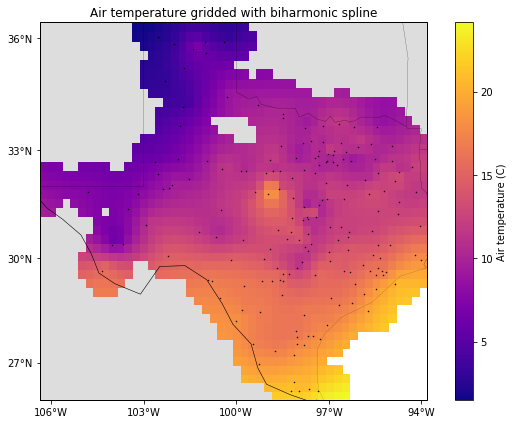

In [3]:
"""
Gridding with splines
=====================
Biharmonic spline interpolation is based on estimating vertical forces acting on an
elastic sheet that yield deformations in the sheet equal to the observed data. The
results are similar to using :class:`verde.ScipyGridder` with ``method='cubic'`` but
the interpolation is usually a bit slower. However, the advantage of using
:class:`verde.Spline` is that we can assign weights to the data and do model selection.
"""
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pyproj
import numpy as np
import verde as vd

# We'll test this on the air temperature data from Texas
data = vd.datasets.fetch_texas_wind()
coordinates = (data.longitude.values, data.latitude.values)
region = vd.get_region(coordinates)

# Use a Mercator projection for our Cartesian gridder
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())

# The output grid spacing will 15 arc-minutes
spacing = 15 / 60

# Now we can chain a blocked mean and spline together. The Spline can be regularized
# by setting the damping coefficient (should be positive). It's also a good idea to set
# the minimum distance to the average data spacing to avoid singularities in the spline.
chain = vd.Chain(
    [
        ("mean", vd.BlockReduce(np.mean, spacing=spacing * 111e3)),
        ("spline", vd.Spline(damping=1e-10, mindist=100e3)),
    ]
)
print(chain)

# We can evaluate model performance by splitting the data into a training and testing
# set. We'll use the training set to grid the data and the testing set to validate our
# spline model.
train, test = vd.train_test_split(
    projection(*coordinates), data.air_temperature_c, random_state=0
)

# Fit the model on the training set
chain.fit(*train)

# And calculate an R^2 score coefficient on the testing set. The best possible score
# (perfect prediction) is 1. This can tell us how good our spline is at predicting data
# that was not in the input dataset.
score = chain.score(*test)
print("\nScore: {:.3f}".format(score))

# Now we can create a geographic grid of air temperature by providing a projection
# function to the grid method and mask points that are too far from the observations
grid_full = chain.grid(
    region=region,
    spacing=spacing,
    projection=projection,
    dims=["latitude", "longitude"],
    data_names=["temperature"],
)
grid = vd.distance_mask(
    coordinates, maxdist=3 * spacing * 111e3, grid=grid_full, projection=projection
)
print(grid)

# Plot the grid and the original data points
plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_title("Air temperature gridded with biharmonic spline")
ax.plot(*coordinates, ".k", markersize=1, transform=ccrs.PlateCarree())
tmp = ax.pcolormesh(
    grid.longitude,
    grid.latitude,
    grid.temperature,
    cmap="plasma",
    transform=ccrs.PlateCarree(),
)
plt.colorbar(tmp).set_label("Air temperature (C)")
# Use an utility function to add tick labels and land and ocean features to the map.
vd.datasets.setup_texas_wind_map(ax, region=region)
plt.tight_layout()
plt.show()

In [89]:
coordinate_names = [*grid_full.coords.keys()]
variable_name = [*grid_full.data_vars.keys()]
l1 = grid_full.coords[coordinate_names[0]].values
l2 = grid_full.coords[coordinate_names[1]].values
import itertools
locations = np.asarray(list(itertools.product(l1, l2)))
variable = grid_full[variable_name[0]].values.flatten(order='F')
d = {coordinate_names[0] :locations[:,0], coordinate_names[1]:locations[:,1], variable_name[0]: variable}
pd.DataFrame(d)

In [94]:
 d = {coordinate_names[0] :locations[:,0], coordinate_names[1]:locations[:,1], variable_name[0]: variable}


In [95]:
pd.DataFrame(d)

,longitude,latitude,temperature
0,-106.3800,25.914600,23.181469
1,-106.3800,26.164586,22.595189
2,-106.3800,26.414571,22.014151
3,-106.3800,26.664557,21.437195
4,-106.3800,26.914543,20.862853
5,-106.3800,27.164529,20.289271
6,-106.3800,27.414514,19.714112
7,-106.3800,27.664500,19.134436
8,-106.3800,27.914486,18.546578
9,-106.3800,28.164471,17.946043


In [32]:
l2 = grid_full.coords[coordinate_names[1]].values

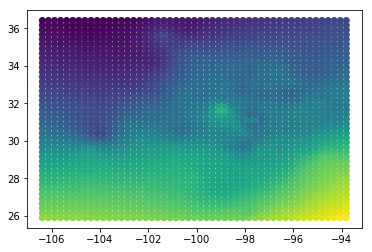

In [87]:
import itertools
plt.scatter(np.asarray(list(itertools.product(l1, l2)))[:,0], np.asarray(list(itertools.product(l1, l2)))[:,1], c=grid_full['temperature'].values.flatten(order='F'))

In [88]:
grid_full[variable_name[0]].values.flatten(order='F')

array([23.1814692 , 22.59518856, 22.01415057, ...,  7.68577027,
        7.39856476,  7.11117047])

In [77]:
l2

array([25.9146    , 26.16458571, 26.41457143, 26.66455714, 26.91454286,
       27.16452857, 27.41451429, 27.6645    , 27.91448571, 28.16447143,
       28.41445714, 28.66444286, 28.91442857, 29.16441429, 29.4144    ,
       29.66438571, 29.91437143, 30.16435714, 30.41434286, 30.66432857,
       30.91431429, 31.1643    , 31.41428571, 31.66427143, 31.91425714,
       32.16424286, 32.41422857, 32.66421429, 32.9142    , 33.16418571,
       33.41417143, 33.66415714, 33.91414286, 34.16412857, 34.41411429,
       34.6641    , 34.91408571, 35.16407143, 35.41405714, 35.66404286,
       35.91402857, 36.16401429, 36.414     ])

In [84]:
grid_full.sel(longitude=-106.38, latitude=25.9146)

KeyError: -106.38